In [1]:
import argparse
import copy
import os
import os.path as osp
import pickle
import time
from pathlib import Path

import matplotlib.image
import mmcv
import numpy as np
import torch
from depth import __version__
from depth.apis import set_random_seed, train_depther
from depth.datasets import build_dataset
from depth.models import build_depther
from depth.utils import collect_env, get_root_logger
from mmcv.runner import init_dist
from mmcv.utils import Config, DictAction, get_git_hash
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# matplotlib.image.imsave('name.png', array)
# im = Image.fromarray(data[0, 0], mode="F").convert("RGB")
# im.save(f"{fname.split('.')[0]}.jpeg")

# ├── data
# │   ├── custom
# │   │   ├── train
# │   │   │   ├── rgb
# │   │   │   │   ├── 0.xxx
# │   │   │   │   ├── 1.xxx
# │   │   │   │   ├── 2.xxx
# │   │   │   ├── depth
# │   │   │   │   ├── 0.xxx
# │   │   │   │   ├── 1.xxx
# │   │   │   │   ├── 2.xxx
# │   │   ├── val
# │   │   │   ...
# │   │   │   ...


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_root = Path("../dataset/depth")


def transform_task_dataset_to_images(task_dataset_root, image_dataset_root):
    all_subdirectories = [f.stem for f in task_dataset_root.iterdir() if f.is_dir()]
    task_names = np.unique(
        [
            "-".join(f.split("-")[:2])
            for f in all_subdirectories
            if "train" in f or "test" in f
        ]
    )
    print(f"{len(task_names)} tasks found: {task_names}")
    for task_name in task_names:
        if task_name == "block-insertion":
            continue
        for _mode in ["train", "test"]:
            mode = _mode if _mode == "train" else "val"
            dataset_root = task_dataset_root / f"{task_name}-{_mode}/"

            color_files = sorted(
                [f for f in (dataset_root / "color").glob("**/*") if f.is_file()]
            )
            depth_files = sorted(
                [f for f in (dataset_root / "depth").glob("**/*") if f.is_file()]
            )

            for color_file, depth_file in tqdm(
                zip(color_files, depth_files), total=len(color_files)
            ):
                color_images = pickle.load(open(color_file, "rb"))
                depth_images = pickle.load(open(depth_file, "rb"))
                color_images_shape = color_images.shape[-3:]

                color_images = color_images.reshape((-1, *color_images_shape))
                depth_images = depth_images.reshape((-1, *color_images_shape[:-1]))

                nb_image_per_color_files = len(color_images)
                nb_image_per_depth_files = len(depth_images)
                assert nb_image_per_color_files == nb_image_per_depth_files

                for index, (color_image, depth_image) in enumerate(
                    zip(color_images, depth_images)
                ):
                    a = (9.8 - 5e-3) / (np.max(depth_image) - np.min(depth_image))
                    b = 5e-3 - a*np.min(depth_image)
                    depth_image = a*depth_image + b
                    filename_color = color_file.stem
                    filename_depth = depth_file.stem
                    assert (
                        filename_color == filename_depth
                    ), f"got 2 different filenames: {filename_color} and {filename_depth}"
                    (image_dataset_root / mode / "rgb").mkdir(
                        parents=True, exist_ok=True
                    )
                    (image_dataset_root / mode / "depth").mkdir(
                        parents=True, exist_ok=True
                    )
                    matplotlib.image.imsave(
                        image_dataset_root
                        / mode
                        / "rgb"
                        / (filename_color.split("-")[0] + f"-{task_name}-{index}.png"),
                        color_image,
                    )
                    matplotlib.image.imsave(
                        image_dataset_root
                        / mode
                        / "depth"
                        / (filename_color.split("-")[0] + f"-{task_name}-{index}.png"),
                        depth_image,
                    )


transform_task_dataset_to_images(Path("dataset"), Path("dataset/depth"))


2 tasks found: ['block-insertion' 'manipulating-rope']


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


In [4]:
# config = "models/finetune_binsformer_swint_w7_nyu.py"
# load_from = "models/binsformer_swint_nyu_converted.pth"
config = "models/finetune_adabins_efnetb5ap_nyu_24e.py"
load_from = "models/adabins_efnetb5_nyu.pth"
work_dir = None
resume_from = None
no_validate = False
gpus = None
gpu_ids = None
seed = 42
deterministic = True
options = None
launcher = "none"
local_rank = 0

if "LOCAL_RANK" not in os.environ:
    os.environ["LOCAL_RANK"] = str(local_rank)


In [5]:
torch.cuda.empty_cache()

cfg = Config.fromfile(config)
if options is not None:
    cfg.merge_from_dict(options)
# set cudnn_benchmark
if cfg.get("cudnn_benchmark", False):
    torch.backends.cudnn.benchmark = True

# work_dir is determined in this priority: CLI > segment in file > filename
if work_dir is not None:
    # update configs according to CLI args if work_dir is not None
    cfg.work_dir = work_dir
elif cfg.get("work_dir", None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = osp.join("./work_dirs", osp.splitext(osp.basename(config))[0])
if load_from is not None:
    cfg.load_from = load_from
if resume_from is not None:
    cfg.resume_from = resume_from
if gpu_ids is not None:
    cfg.gpu_ids = gpu_ids
else:
    cfg.gpu_ids = range(1) if gpus is None else range(gpus)

# init distributed env first, since logger depends on the dist info.
if launcher == "none":
    distributed = False
# else:
#     distributed = True
#     init_dist(launcher, **cfg.dist_params)

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# dump config
cfg.dump(osp.join(cfg.work_dir, osp.basename(config)))
# init the logger before other steps
timestamp = time.strftime("%Y%m%d_%H%M%S", time.localtime())
log_file = osp.join(cfg.work_dir, f"{timestamp}.log")
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

# init the meta dict to record some important information such as
# environment info and seed, which will be logged
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = "\n".join([f"{k}: {v}" for k, v in env_info_dict.items()])
dash_line = "-" * 60 + "\n"
logger.info("Environment info:\n" + dash_line + env_info + "\n" + dash_line)
meta["env_info"] = env_info

# log some basic info
logger.info(f"Distributed training: {distributed}")
logger.info(f"Config:\n{cfg.pretty_text}")

# set random seeds
if seed is not None:
    logger.info(f"Set random seed to {seed}, deterministic: " f"{deterministic}")
    set_random_seed(seed, deterministic=deterministic)
cfg.seed = seed
meta["seed"] = seed
meta["exp_name"] = osp.basename(config)

# model = build_depther(
#     cfg.model, train_cfg=cfg.get("train_cfg"), test_cfg=cfg.get("test_cfg")
# )
# model.init_weights()

# for param in model.backbone.parameters():
#     model.backbone.eval()
#     param.requires_grad = False

# NOTE: set all the bn to syncbn
# import torch.nn as nn

# if cfg.get("SyncBN", False):
#     model = nn.SyncBatchNorm.convert_sync_batchnorm(model)

# logger.info(model)

datasets = [build_dataset(cfg.data.train)]
# if len(cfg.workflow) == 2:
#     val_dataset = copy.deepcopy(cfg.data.val)
#     val_dataset.pipeline = cfg.data.train.pipeline
#     datasets.append(build_dataset(val_dataset))
# if cfg.checkpoint_config is not None:
#     # save depth version, config file content and class names in
#     # checkpoints as meta data
#     cfg.checkpoint_config.meta = dict(
#         depth_version=f"{__version__}+{get_git_hash()[:7]}", config=cfg.pretty_text
#     )
# # passing checkpoint meta for saving best checkpoint
# meta.update(cfg.checkpoint_config.meta)
# train_depther(
#     model,
#     datasets,
#     cfg,
#     distributed=distributed,
#     validate=(not no_validate),
#     timestamp=timestamp,
#     meta=meta,
# )


2023-01-01 20:05:05,843 - depth - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) [GCC 9.4.0]
CUDA available: True
GPU 0: Tesla T4
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GCC: gcc (Debian 8.3.0-6) 8.3.0
PyTorch: 1.8.1+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70
  - CuDNN 7.6.3
  - Magma 2.5.2
  - B

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


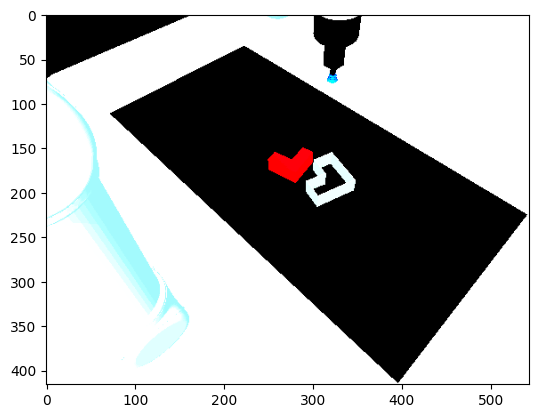

In [15]:
plt.imshow(datasets[0][1]["img"]._data.permute(1, 2, 0))

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    a = model(
        [datasets[0][0]["img"]._data.unsqueeze(0).to(device)],
        [[datasets[0][0]["img_metas"]._data]],
        datasets[0][0]["depth_gt"]._data,
        return_loss=False
    )


NameError: name 'model' is not defined

In [25]:
a = datasets[0][1]["depth_gt"]._data
a.shape

torch.Size([1, 416, 544, 4])

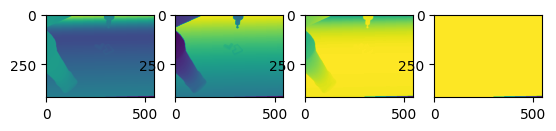

In [23]:
fig, axs = plt.subplots(1, 4)

for i in range(4):
    axs[i].imshow(a[:, :, :, i].squeeze())